1. Creating a Databricks Notebook
Create a new Databricks notebook.
Use Python code to demonstrate basic operations (such as reading data and
performing calculations).

In [0]:
# Import necessary libraries
import pandas as pd
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("DatabricksIntro").getOrCreate()

# Create a sample dataset
data = [("Alice", 25), ("Bob", 30), ("Charlie", 35)]
df = spark.createDataFrame(data, ["Name", "Age"])

# Show the data
df.show()

# Perform a basic calculation
avg_age = df.agg({"Age": "avg"}).collect()[0][0]
print(f"Average age: {avg_age:.2f}")

# Convert to Pandas DataFrame for further analysis
pandas_df = df.toPandas()
print(pandas_df.describe())

+-------+---+
|   Name|Age|
+-------+---+
|  Alice| 25|
|    Bob| 30|
|Charlie| 35|
+-------+---+

Average age: 30.00
        Age
count   3.0
mean   30.0
std     5.0
min    25.0
25%    27.5
50%    30.0
75%    32.5
max    35.0


2. Setting Up Azure Databricks Workspace and Configuring Clusters
Task: Configuring Clusters
Set up an Azure Databricks cluster.
Configure the cluster with appropriate node sizes and autoscaling.
Attach your notebook to the cluster and run basic Python code to verify
configuration.

In [0]:
# Run a simple operation to test the cluster
df = spark.range(1000000)
count = df.count()
print(f"Number of rows: {count}")

Number of rows: 1000000


3. Real-Time Data Processing with Databricks
Task: Implementing Databricks for Real-Time Data Processing
Create a notebook to process real-time data using streaming APIs.
Use a dataset with 1 million records, including fields such as event_time ,
event_type , user_id , and amount , to simulate a streaming data scenario.
Perform real-time data aggregation (e.g., summing up the amount per minute or
event type).


In [0]:
dbutils.fs.cp("file:/Workspace/Shared/million_records.csv","dbfs:/FileStore/streaming_data.csv")
dbutils.fs.cp("file:/Workspace/Shared/sales_data2.csv","dbfs:/FileStore/sales_data.csv")
dbutils.fs.cp("file:/Workspace/Shared/transaction_data.csv","dbfs:/FileStore/exe_transaction_data.csv")

True

In [0]:
# Use spark.readStream to simulate real-time data processing.
schema="event_time TIMESTAMP, event_type STRING, user_id STRING, amount DOUBLE"
streamind_data=spark.readStream.format("csv").schema(schema).option("header","true").load("dbfs:/FileStore/")
# Real-time aggregation
aggregated_data=(streamind_data.groupBy("event_type").agg({"amount":"sum"}).withColumnRenamed("sum(amount)","total_amount"))
query = (aggregated_data.writeStream
         .outputMode("complete")
         .format("console")
         .start())
# Wait for the streams to finish
query.awaitTermination(60)  # Wait for 60 seconds

False

4. Data Exploration and Visualization in Databricks
Task: Visualizing Data in Databricks
Use a large dataset of at least 10,000 rows, such as sales or transaction data,
for exploratory data analysis (EDA).
Create multiple visualizations, including bar charts and scatter plots, to
explore relationships between variables.

In [0]:
from pyspark.sql.functions import col
df = spark.read.csv("dbfs:/FileStore/sales_data.csv", header=True, inferSchema=True)
df = df.withColumn("amount", df["Price"].cast("double")) \
.withColumn("quantity", df["Quantity"].cast("int"))

# Show the first few records
df.show(5)

+----------+------+--------+--------+-----+------+
|      Date|Region| Product|quantity|Price|amount|
+----------+------+--------+--------+-----+------+
|2024-09-01| North|Widget A|      10| 25.5|  25.5|
|2024-09-01| South|Widget B|       5|15.75| 15.75|
|2024-09-02| North|Widget A|      12| 25.5|  25.5|
|2024-09-02|  East|Widget C|       8| 22.5|  22.5|
|2024-09-03|  West|Widget A|      15| 25.5|  25.5|
+----------+------+--------+--------+-----+------+
only showing top 5 rows



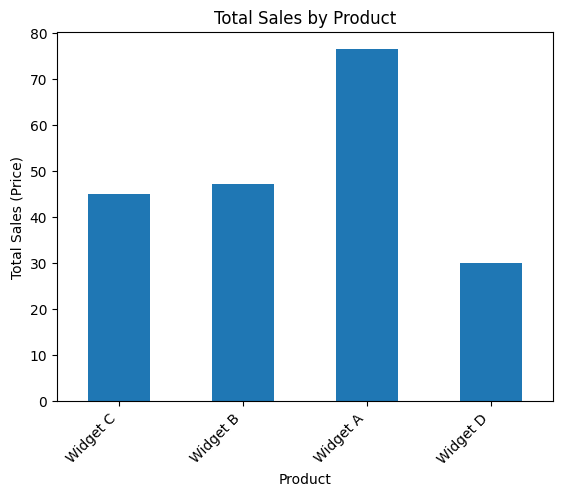

In [0]:
import matplotlib.pyplot as plt

# Convert the total sales per product to Pandas
df_pandas_category = df.groupBy("Product").agg({"amount": "sum"}).toPandas()

# Plot using Matplotlib
df_pandas_category.plot(kind='bar', x='Product', y='sum(amount)', legend=False)

# Customize the plot
plt.title("Total Sales by Product")
plt.xlabel("Product")
plt.ylabel("Total Sales (Price)")
plt.xticks(rotation=45, ha='right')
plt.show()

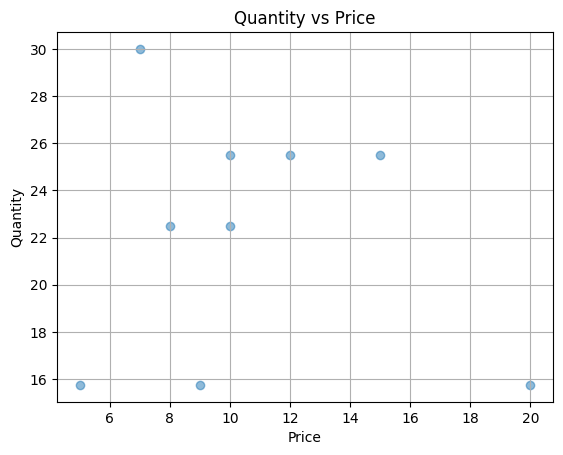

In [0]:
# Convert the necessary columns to Pandas
df_pandas_scatter = df.select("Quantity", "Price").toPandas()

# Plot using Matplotlib
plt.scatter(df_pandas_scatter['Quantity'], df_pandas_scatter['Price'], alpha=0.5)

# Customize the plot
plt.title("Quantity vs Price")
plt.xlabel("Price")
plt.ylabel("Quantity")
plt.grid(True)
plt.show()

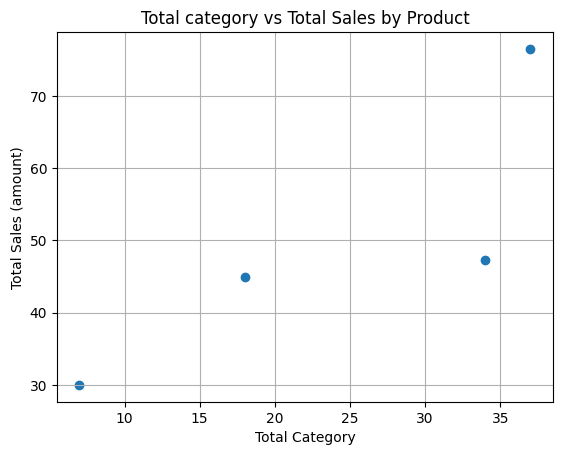

In [0]:
# Group by product, sum the quantity and price, and convert to Pandas
df_pandas_quantity_vs_sales = df.groupBy("Product") \
    .agg({"Quantity": "sum", "Price": "sum"}).toPandas()

# Plot using Matplotlib
plt.scatter(df_pandas_quantity_vs_sales['sum(Quantity)'], df_pandas_quantity_vs_sales['sum(Price)'])

# Customize the plot
plt.title("Total category vs Total Sales by Product")
plt.xlabel("Total Category")
plt.ylabel("Total Sales (amount)")
plt.grid(True)
plt.show()

5. Reading and Writing Data in Databricks
Task: Reading and Writing Data in Various Formats
Read data from different formats: CSV, JSON, Parquet, and Delta.
Use a large dataset with at least 100,000 rows containing customer and
transaction data.
Write the data to Delta format and other formats like Parquet and JSON.

In [0]:
df_csv = spark.read.csv("dbfs:/FileStore/sales_data.csv", header=True, inferSchema=True)

# Writing to Delta format
df_csv.write.format("delta").mode("overwrite").save("dbfs:/FileStore/delta_table")
print("Writing to the delta table completed")

# Writing to Parquet
df_csv.write.mode("overwrite").parquet("dbfs:/FileStore/parquet_table")
print("Writing to the parquet file completed")

# Writing to JSON
df_csv.write.mode("overwrite").json("dbfs:/FileStore/json_table")
print("Writing to the json file completed")

Writing to the delta table completed
Writing to the parquet file completed
Writing to the json file completed


6. Analyzing and Visualizing Streaming Data with Databricks
Task: Analyzing Streaming Data
Use a dataset with at least 500,000 records for streaming data analysis.
Visualize real-time data changes over time using Databricks' built-in
visualization tools.

In [0]:
# Use Spark streaming to analyze and visualize streaming data in real time
streaming_data = (spark.readStream.format("csv").option("header", "true").schema(schema).load("dbfs:/FileStore/"))

streaming_data_with_watermark = streaming_data.withWatermark("event_time", "10 minutes")

# Real-time visualization of total amount over time
streaming_data_with_watermark.groupBy("event_time").sum("amount").writeStream.outputMode("append").format("console").start()

7. Introduction to Databricks Delta Lake
Task: Using Delta Lake for Data Versioning

Create a Delta table from a dataset of at least 500,000 rows.
Update the table over time and demonstrate the ability to time travel between
versions of the table.
Optimize the Delta table and perform operations like compaction and vacuuming.

In [0]:
df.write.format("delta").mode("overwrite").save("/delta/new_data")

# Updating the Delta Table
spark.sql("UPDATE delta.`/delta/new_data` SET Quantity = Quantity * 25 WHERE OrderID = 1003")
updated_df = spark.read.format("delta").load("/delta/new_data")
display(updated_df)

# Reading the previous version of the Delta Table
previous_version = spark.read.format("delta").option("versionAsOf", 0).load("/delta/new_data")
display(previous_version)

# Optimize the Delta table
spark.sql("""
    OPTIMIZE delta.`/delta/new_data` ZORDER BY OrderID
""")

# Vacuum the Delta table
spark.sql("""
    VACUUM delta.`/delta/new_data` RETAIN 168 HOURS
""")


OrderID,OrderDate,CustomerID,Product,Quantity,Price
1001,2024-01-15,C001,Widget A,10,25.5
1002,2024-01-16,C002,Widget B,5,15.75
1004,2024-01-17,C003,Widget A,15,25.5
1005,2024-01-18,C004,Widget D,7,30.0
1006,2024-01-19,C002,Widget B,9,15.75
1007,2024-01-20,C005,Widget C,12,22.5
1008,2024-01-21,C003,Widget A,10,25.5
1003,2024-01-16,C001,Widget C,200,22.5


OrderID,OrderDate,CustomerID,Product,Quantity,Price
1001,2024-01-15,C001,Widget A,10,25.5
1002,2024-01-16,C002,Widget B,5,15.75
1003,2024-01-16,C001,Widget C,8,22.5
1004,2024-01-17,C003,Widget A,15,25.5
1005,2024-01-18,C004,Widget D,7,30.0
1006,2024-01-19,C002,Widget B,9,15.75
1007,2024-01-20,C005,Widget C,12,22.5
1008,2024-01-21,C003,Widget A,10,25.5


DataFrame[path: string]

8. Managed and Unmanaged Tables
Task: Creating Managed and Unmanaged Tables
Create a managed table with at least 100,000 rows of sales or transaction data.
Create an unmanaged table with similar data, specifying an external location
for the data.
Perform basic operations like selecting, updating, and deleting records from
both tables.

In [0]:
# Creating a managed table
df.write.saveAsTable("managed_sales_data")

# Creating an unmanaged table with external location
df.write.option("path", "/mnt/data/external_sales_data").saveAsTable("unmanaged_sales_data")

# Query both tables
spark.sql("SELECT * FROM managed_sales_data").show()
spark.sql("SELECT * FROM unmanaged_sales_data").show()


+-------+----------+----------+--------+--------+-----+
|OrderID| OrderDate|CustomerID| Product|Quantity|Price|
+-------+----------+----------+--------+--------+-----+
|   1001|2024-01-15|      C001|Widget A|      10| 25.5|
|   1002|2024-01-16|      C002|Widget B|       5|15.75|
|   1003|2024-01-16|      C001|Widget C|       8| 22.5|
|   1004|2024-01-17|      C003|Widget A|      15| 25.5|
|   1005|2024-01-18|      C004|Widget D|       7| 30.0|
|   1006|2024-01-19|      C002|Widget B|       9|15.75|
|   1007|2024-01-20|      C005|Widget C|      12| 22.5|
|   1008|2024-01-21|      C003|Widget A|      10| 25.5|
+-------+----------+----------+--------+--------+-----+

+-------+----------+----------+--------+--------+-----+
|OrderID| OrderDate|CustomerID| Product|Quantity|Price|
+-------+----------+----------+--------+--------+-----+
|   1001|2024-01-15|      C001|Widget A|      10| 25.5|
|   1002|2024-01-16|      C002|Widget B|       5|15.75|
|   1003|2024-01-16|      C001|Widget C|       

9. Views and Temporary Views
Task: Working with Views in Databricks
Create a view, temporary view, and global temporary view from a dataset
containing at least 100,000 rows.
Perform queries on these views and analyze their behavior across different
sessions.

In [0]:
# Create a temporary view
df.createOrReplaceTempView("temp_sales_view")

# Create a global temporary view
df.createGlobalTempView("global_temp_sales_view")

# spark.catalog.dropGlobalTempView("global_temp_sales_view")

# Query the temporary and global views
spark.sql("SELECT * FROM temp_sales_view").show()
spark.sql("SELECT * FROM global_temp.global_temp_sales_view").show()

+-------+----------+----------+--------+--------+-----+
|OrderID| OrderDate|CustomerID| Product|Quantity|Price|
+-------+----------+----------+--------+--------+-----+
|   1001|2024-01-15|      C001|Widget A|      10| 25.5|
|   1002|2024-01-16|      C002|Widget B|       5|15.75|
|   1003|2024-01-16|      C001|Widget C|       8| 22.5|
|   1004|2024-01-17|      C003|Widget A|      15| 25.5|
|   1005|2024-01-18|      C004|Widget D|       7| 30.0|
|   1006|2024-01-19|      C002|Widget B|       9|15.75|
|   1007|2024-01-20|      C005|Widget C|      12| 22.5|
|   1008|2024-01-21|      C003|Widget A|      10| 25.5|
+-------+----------+----------+--------+--------+-----+

+-------+----------+----------+--------+--------+-----+
|OrderID| OrderDate|CustomerID| Product|Quantity|Price|
+-------+----------+----------+--------+--------+-----+
|   1001|2024-01-15|      C001|Widget A|      10| 25.5|
|   1002|2024-01-16|      C002|Widget B|       5|15.75|
|   1003|2024-01-16|      C001|Widget C|       